In [1]:
# basics
import os, sys

# arrays
import numpy as np

# append sscode to path
sys.path.insert(0, '..')
# data_path = '/data/' #'/data/storm_surge_data/'
# os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.config import default_location, \
    default_region, default_region_reduced
from sscode.data import Loader
from sscode.pca_new import PCA_DynamicPred

# warnings
import warnings
warnings.filterwarnings('ignore')

# for autocomplete code
%config Completer.use_jedi = False

import gc

DATA PATH /home/javitausia/Documentos/geocean-nz-ss/data


In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False, 
    time_resample='1D', load_winds=True
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



In [3]:
class PCA_PreComputer(object):
    """
    This class Experiment summarizes all the previous work done with the linear, the
    knn models and the xgboost models, as this class allows the user to perform a detailed 
    analysis of one requested model given a set of parameters

    """

    def __init__(self, slp_data,
                 wind_data,
                 ss_data,
                 sites_to_analyze,
                 pca_attrs,
                 pcs_folder):
        """
        As the initializator, the __init__ function creates the instance of the class,
        given a set of parameters, which are described below

        Args:
            slp_data (xarray.Dataset): These are the sea-level-pressure fields, previously
                loaded with the Loader class, loader.predictor_slp!!
            wind_data (xarray.Dataset): These are the wind fields, previously
                loaded with the Loader class, loader.predictor_wind!!
            ss_data (xarray.Dataset): This is the storm surge from the moana hindcast, previously
                loaded with the Loader class, loader.predictand!!
            sites_to_analyze (list, optional): This is the list with all the moana v2
                hindcast locations to analyze. Defaults to random locations.
            pca_attrs (dict, optional): PCA dictionary with all the parameters to use in pca.
                Defaults to pca_attrs_default.
            pca_folder (string, optionl): The folder from/in which the PCs should be loaded/saved.
        """

        # lets build the experiment!! + with CFSR
        self.predictor_data = 'cfsr'

        # save class simplest attributes
        self.slp_data = slp_data
        self.wind_data = wind_data
        self.ss_data = ss_data
        self.ss_sites = sites_to_analyze
        self.pca_attrs = pca_attrs
        self.pcs_folder = pcs_folder
    

    def compute_pcas(self):
        """
        This function goes over all the sites/configurations and computes
        and stores the results of the PCA analysis if not already available.

        Args:


        Returns:
            
            
        """

        for isite,site in enumerate(self.ss_sites):

            # we first load in memmory the selected site
            ss_site = self.ss_data.isel(site=site)[[
                'ss','lat','lon'
            ]].load() # load the ss and the location of the site
            site_location = (ss_site.lon.values,ss_site.lat.values)

            # lets iterate over all the pca_attrs + model_attrs
            counter = 0
            for i_parameters,parameters in zip(
                [(icg,iw,itl,itr,ir) \
                    for icg in [i for i in range(len(list(self.pca_attrs.values())[0]))] \
                    for iw in [i for i in range(len(list(self.pca_attrs.values())[1]))] \
                    for itl in [i for i in range(len(list(self.pca_attrs.values())[2]))] \
                    for itr in [i for i in range(len(list(self.pca_attrs.values())[3]))] \
                    for ir in [i for i in range(len(list(self.pca_attrs.values())[4]))]]
                , [(cg,w,tl,tr,r) \
                    for cg in list(self.pca_attrs.values())[0] \
                    for w in list(self.pca_attrs.values())[1] \
                    for tl in list(self.pca_attrs.values())[2] \
                    for tr in list(self.pca_attrs.values())[3] \
                    for r in list(self.pca_attrs.values())[4]]
            ):  
            
                # Some info
                print(
                    '\n --------------------------------------------------------- \
                    \n\n Experiment {} in site {}, coords = {} ...... \
                    \n\n pca_params = {} \n\n \
                    \n\n and iteration with indexes = {} \
                    \n\n ---------------------------------------------------------'.format(
                        counter+1, # this is just the counter
                        site, # site to analyze in this loop
                        site_location, # site coordinates
                        dict(zip(self.pca_attrs.keys(),parameters[:5])),
                        i_parameters # this are the parameters indexes
                    ), end='\r'
                )

                # perform the experiment
                dict_to_pca = dict(zip(list(self.pca_attrs.keys()),parameters[:5]))
                trash = dict_to_pca.pop('winds')
                
                # change region parameter if local area is required
                if parameters[4][0]=='local':
                    local_region = (True,(
                        site_location[0]-parameters[4][1][0], # new lon / lat region
                        site_location[0]+parameters[4][1][0],
                        site_location[1]+parameters[4][1][1],
                        site_location[1]-parameters[4][1][1]
                    ))
                    dict_to_pca['region'] = local_region

                pca_data, pca_scaler = PCA_DynamicPred(
                    self.slp_data,
                    pres_vars=('SLP','longitude','latitude'),
                    wind=self.wind_data if parameters[1] else None,
                    wind_vars=('wind_proj_mask','lon','lat','U_GRD_L103','V_GRD_L103'),
                    pca_plot=(True,False,1),
                    verbose=True,
                    pcs_folder=self.pcs_folder,
                    site_id=site,
                    site_location=site_location,
                    pca_percent=0.99,
                    pca_method='cpu',
                    **dict_to_pca # extra arguments without the winds
                ).pcs_get()
                
                # this seems necessary to keep memory under control    
                del pca_data
                del pca_scaler
                gc.collect()


 ---------------------------------------------------------                     

 Experiment 1 in site 116, coords = (array(168.34508816), array(-46.62520765)) ......                     

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

                     

 and iteration with indexes = (0, 0, 0, 0, 0)                     

time resample 1D------------------------------------------
/home/javitausia/Documentos/geocean-nz-ss/data/pcs/ ['local_2.5_-2.5', '116', 'winds', 'gradients', '1D', 'tl3']
FILE /home/javitausia/Documentos/geocean-nz-ss/data/pcs/local_2.5_-2.5_116_winds_gradients_1D_tl3.nc

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 160, lon: 161, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -20.14 -20.45 -20.76 ... -69.16 -69.47 -69.78
  * lon             (lon) float32 140.0 1

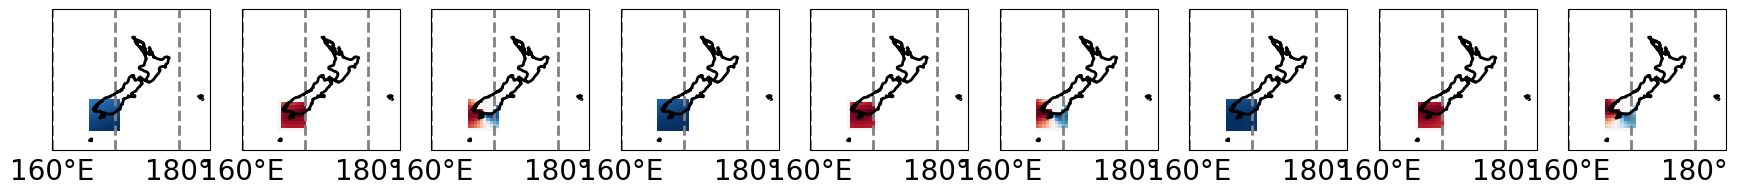

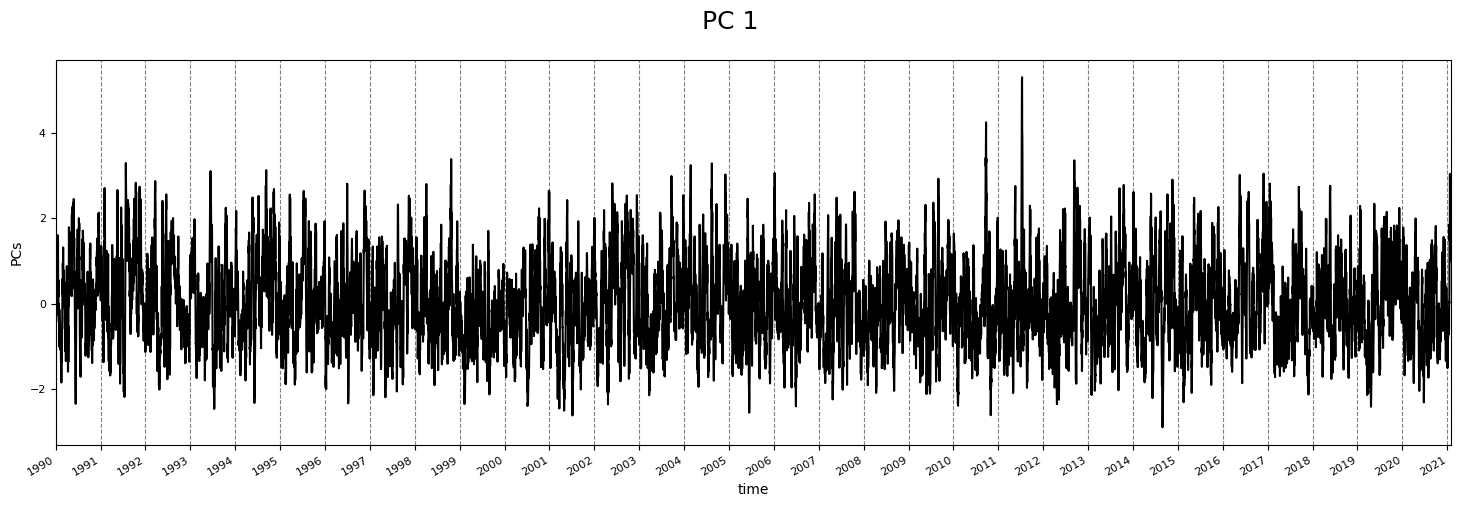


 ---------------------------------------------------------                     

 Experiment 1 in site 689, coords = (array(174.75314861), array(-41.37103813)) ......                     

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

                     

 and iteration with indexes = (0, 0, 0, 0, 0)                     

time resample 1D------------------------------------------
/home/javitausia/Documentos/geocean-nz-ss/data/pcs/ ['local_2.5_-2.5', '689', 'winds', 'gradients', '1D', 'tl3']
FILE /home/javitausia/Documentos/geocean-nz-ss/data/pcs/local_2.5_-2.5_689_winds_gradients_1D_tl3.nc

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 160, lon: 161, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -20.14 -20.45 -20.76 ... -69.16 -69.47 -69.78
  * lon             (lon) float32 140.0 1

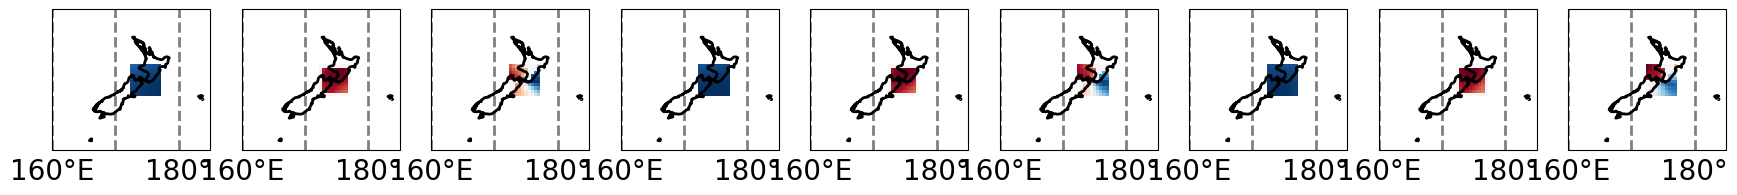

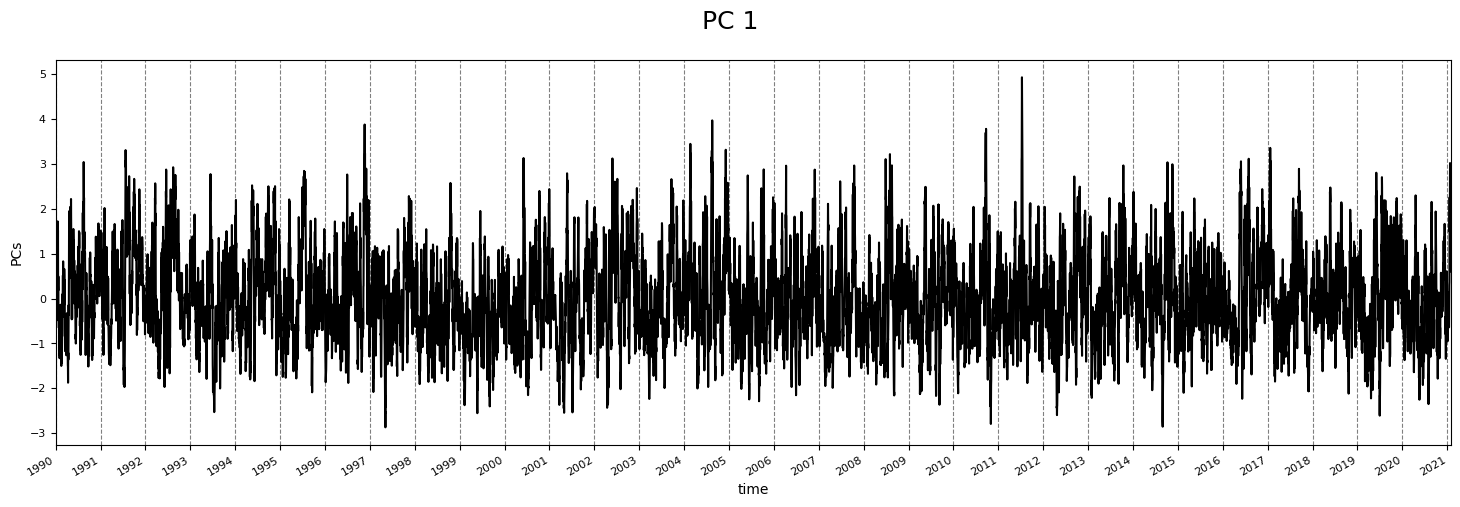


 ---------------------------------------------------------                     

 Experiment 1 in site 1146, coords = (array(178.13853904), array(-37.51451809)) ......                     

 pca_params = {'calculate_gradient': True, 'winds': True, 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5))} 

                     

 and iteration with indexes = (0, 0, 0, 0, 0)                     

time resample 1D------------------------------------------
/home/javitausia/Documentos/geocean-nz-ss/data/pcs/ ['local_2.5_-2.5', '1146', 'winds', 'gradients', '1D', 'tl3']
FILE /home/javitausia/Documentos/geocean-nz-ss/data/pcs/local_2.5_-2.5_1146_winds_gradients_1D_tl3.nc

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 160, lon: 161, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -20.14 -20.45 -20.76 ... -69.16 -69.47 -69.78
  * lon             (lon) float32 140.

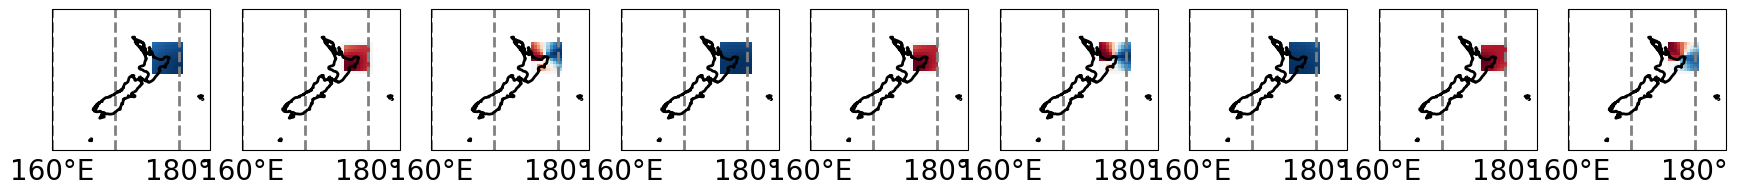

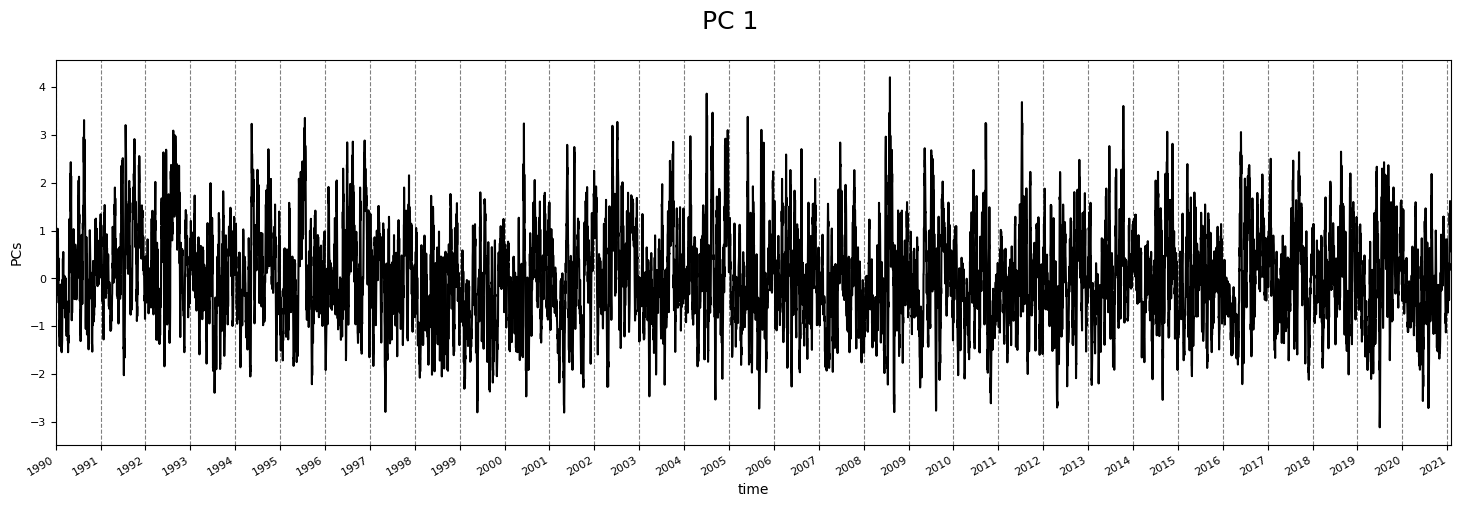

In [4]:
pca_attrs = {
    'calculate_gradient': [True],
    'winds': [True],
    'time_lapse': [3], # 1 equals to NO time delay 
    'time_resample': ['1D'], # 1D and 12H, 6H available...
    'region': [('local',(2.5,2.5))] # (True,default_region_reduced)
}

sites_to_analyze = np.unique( # closest Moana v2 Hindcast to tidal gauges
    [  689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
       1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
       1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]
    # [ 613,488,1442,1217,578,200,1177,1025,689,949,224,1146 ]
    # [ 1174,1260,1217 ]
)[::10]

# sites_to_analyze = range(1448) # 1448 points in total


PCA_precomputer = PCA_PreComputer(
    load_cfsr_moana_uhslc.predictor_slp,
    load_cfsr_moana_uhslc.predictor_wind,
    load_cfsr_moana_uhslc.predictand, # all the sites are passed to exp at first
    sites_to_analyze=sites_to_analyze, 
    pca_attrs=pca_attrs,
    pcs_folder='/home/javitausia/Documentos/geocean-nz-ss/data/pcs/'
)

PCA_precomputer.compute_pcas()

In [5]:
print("Done")

Done
